# Dataset Information

Dataset summary table and example partition graphs presented in Section 3.1.

1. [Summary Table](#Summary-Table)
2. [PowN Partition Example](#PowN-Partition-Example)
3. [DirY Partition Example](#DirY-Partition-Example)

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect,sys,os,re

import datasets,partitions,utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Vehicle Load dataset natural partition

In [7]:
p=datasets.VehicleLoanDefaultDataset().natural_partition

In [8]:
utils.visualize_partition(p,title='Vehicle Loan Default dataset natural partition',fn='tmp/natural_partition_ex.png')

<Figure size 640x480 with 0 Axes>

## Summary Table

In [9]:
dataset_classes=inspect.getmembers(sys.modules['datasets'], inspect.isclass)
dataset_classes=[(i,j) for i,j in dataset_classes if i!="Dataset"]

In [19]:
datasets_summary=[]

for name,dataset_class in dataset_classes:
    
    dataset=dataset_class()
    X,y=dataset.X_y
    
    # No. of classes
    n_classes=np.nan if dataset.task=='regression' else y.nunique()
    
    # No. of instances and attributes
    n_instances,n_attributes=y.size,dataset.load_raw().shape[1]
    
    # Partitioned on Col
    p_on=f'{dataset.partition_on_column} ({len(dataset.natural_partition)})' if hasattr(dataset,'partition_on_column') else '-'
    
    datasets_summary.append([dataset,dataset.task,n_instances,n_attributes,n_classes,p_on])    

In [20]:
datasets_df=pd.DataFrame(
    datasets_summary,
    columns=['dataset','task','N','# of attributes','# of classes','partitioned on']
).sort_values('task')

datasets_df=datasets_df.fillna('-')
datasets_df['task']=datasets_df['task'].str.title()
datasets_df['N']=((datasets_df['N']/1000).astype('int')).astype('str')+'k'
datasets_df

,dataset,task,N,# of attributes,# of classes,partitioned on
1,Census Income,Classification,32k,15,2.0,native-country (3)
2,Cover Type,Classification,495k,55,2.0,-
3,Credit Card Default,Classification,30k,25,2.0,-
7,Hotel Reservations,Classification,36k,19,2.0,-
9,Vehicle Loan Default,Classification,95k,41,2.0,branch_id (12)
0,Black Friday,Regression,550k,12,-,City_Category (3)
4,Diamonds,Regression,53k,10,-,-
5,Flight Price,Regression,300k,12,-,airline (6)
6,Fried,Regression,40k,11,-,-
8,Vehicle,Regression,30k,26,-,state (9)


In [21]:
datasets_df.to_csv('tmp/datasets_df.csv',index=False)

In [22]:
os.makedirs('tmp/setup/',exist_ok=True)

## PowN Partition Example

In [24]:
X,y=datasets.VehicleLoanDefaultDataset().X_y

In [25]:
def power_partitions_(c,a):
    partition={i:(X.iloc[ixs],y.iloc[ixs]) for i,ixs in partitions.power_partition_n(y,c,a).items()}
    xs,ys=[],[]
    p=sorted(partition,key=lambda i:len(partition[i][1]))
    for island in p:
        xs.append(str(island))
        ys.append(len(partition[island][1]))
    return xs,ys

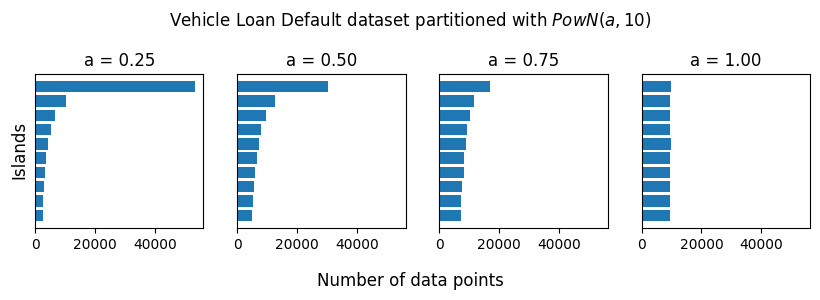

In [30]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True,sharex=True,figsize=(10,2))

for ax, a in zip([ax1, ax2, ax3, ax4],[0.25,0.50,0.75,1.0]):
    
    xs,ys=power_partitions_(10,a)
    ax.barh(xs, ys)
    ax.set_yticks([])
    ax.set_title(f'a = {a:.2f}')
    
f.suptitle(r'Vehicle Loan Default dataset partitioned with $PowN(a,10)$',y=1.20)
f.supylabel('Islands',x=0.1)
f.supxlabel('Number of data points',y=-0.20)

f.savefig('tmp/setup/powN.png',bbox_inches='tight')
    

## DirY Partition Example

In [16]:
X,y=datasets.VehicleLoanDefaultDataset().X_y

In [17]:
def dir_partitions_(c,alpha,y,X):
    partition={i:(X.iloc[ixs],y.iloc[ixs]) for i,ixs in partitions.dirichlet_partition(y,c,alpha).items()}

    _,yAll=utils.join_partitions(partition,partition.keys())
    labels=yAll.unique()
        
    clients=list(partition.keys())

    # Class -> array with no. of elements of class per client
    # E.g. 0 -> [100,200,300] implies client 0 has 100 class 0 examples and so on

    class_client_counts={label:[] for label in labels}

    for label in labels:
        counts_all=np.zeros(len(clients))
        for c,(client,(_,y)) in enumerate(partition.items()):
            counts_all[c]=(y==label).sum()
        
        class_client_counts[label]=counts_all
    
    return clients,class_client_counts
    

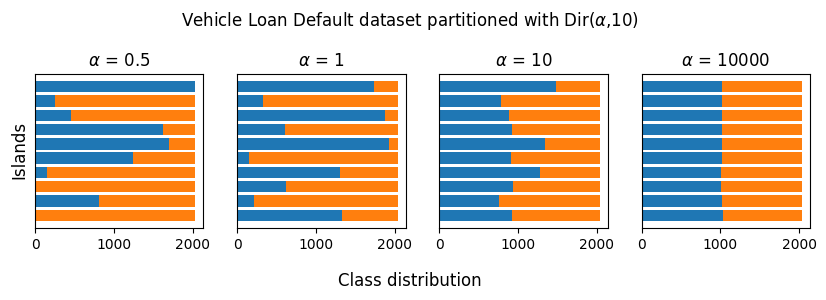

In [18]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True,sharex=True,figsize=(10,2))


alpha=0.5
clients,class_client_counts=dir_partitions_(10,alpha,y,X)
prev=None
for k,v in class_client_counts.items():
    ax1.barh(clients, v,label=k,left=prev)
    ax1.set_yticks([])
    prev=v
ax1.set_title(r'$\alpha$'+f' = {alpha}')

alpha=1
clients,class_client_counts=dir_partitions_(10,alpha,y,X)
prev=None
for k,v in class_client_counts.items():
    ax2.barh(clients, v,label=k,left=prev)
    prev=v
ax2.set_title(r'$\alpha$'+f' = {alpha}')


alpha=10
clients,class_client_counts=dir_partitions_(10,alpha,y,X)
prev=None
for k,v in class_client_counts.items():
    ax3.barh(clients, v,label=k,left=prev)
    prev=v
ax3.set_title(r'$\alpha$'+f' = {alpha}')

alpha=10000
clients,class_client_counts=dir_partitions_(10,alpha,y,X)
prev=None
for k,v in class_client_counts.items():
    ax4.barh(clients, v,label=k,left=prev)
    prev=v
ax4.set_title(r'$\alpha$'+f' = {alpha}')

f.suptitle(r'Vehicle Loan Default dataset partitioned with Dir($\alpha$,10)',y=1.20)
f.supylabel('Islands',x=0.1)
f.supxlabel('Class distribution',y=-0.20)

f.savefig('tmp/setup/dirY.png',bbox_inches='tight')
